In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm.notebook

import torch
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

from svd_utils import GraphConvolutionBSSVD

In [2]:
args = {
    'cuda': False,
    'dataset': 'cora',
    'datapath': '../DropEdge/data/',
    'fastmode': False,
    'seed': 42,
    'epochs': 400,
    'lr': 0.01,
    'lradjust': False,
    'weight_decay': 0.005,
    'warm_start': '',
    'debug': True,
    'early_stopping': 400,
    'no_tensorboard': False,
    'normalization': 'FirstOrderGCN',
    'sampling_percent': 0.7,
    'task_type': 'full',
}

sampler = Sampler(args['dataset'], args['datapath'], args['task_type'])
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(cuda=args['cuda'])
nfeat = sampler.nfeat
nclass = sampler.nclass

model_args = {
    'nfeat': sampler.nfeat,
    'nclass': sampler.nclass,
    'nhid': 128,
    'nhidlayer': 1,
    'dropout': 0.8,
    'baseblock': 'mutigcn',
    'inputlayer': 'gcn',
    'outputlayer': 'gcn',
    'nbaselayer': 3,
    'activation': F.relu,
    'withbn': False,
    'withloop': False,
    'aggrmethod': 'nores',
    'mixmode': False
}

Load full supervised task.


In [3]:
def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [4]:
def fit_model(model, idx_train, idx_val, num_epochs=10, verbose=0, normalize=None):
    (train_adj, train_fea) = sampler.randomedge_sampler(
        percent=1.0,
        normalization=args['normalization'],
        cuda=args['cuda'])
    (val_adj, val_fea) = sampler.get_val_set(normalization=args['normalization'], cuda=args['cuda'])
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(parameters, lr=args['lr'], weight_decay=args['weight_decay'])
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[200, 300, 400, 500, 600, 700],
                                               gamma=0.5)
    
    history = defaultdict(list)
                
    for ep in range(1, num_epochs+1):
#         if not normalize is None and ep % normalize == 0 and ep < (num_epochs-normalize):
        if normalize and ep in normalize:
            print("Normalize")
            for i in range(model_args['nbaselayer']):
                model.midlayer[0].model.hiddenlayers[i].normalize()
            model.ingc.normalize()
            model.outgc.normalize()

        
        model.train()
        optimizer.zero_grad()
        output = model(train_fea, train_adj)
        
        
        train_loss = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        
        train_loss.backward()
        optimizer.step()
        
        history['train_loss'].append(train_loss.item())
        history['train_acc'].append(acc_train.item())
        
        # Validate
        model.eval()
        output = model(val_fea, val_adj)
        val_loss = F.nll_loss(output[idx_val], labels[idx_val]).item()
        val_acc = accuracy(output[idx_val], labels[idx_val]).item()
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if verbose > 0 and (ep % verbose == 0 or ep == num_epochs):
            print("epoch: {:3} TRAIN: acc={:.3}; loss={:.3} VALID: acc={:.3}; loss={:.3}".format(
                ep,
                acc_train.item(), train_loss.item(),
                val_acc, val_loss
            ))
            
    
        
    return history

In [6]:
def plot_history(history, test_loss=None, test_acc=None, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    
    if title:
        fig.suptitle(title, fontsize=16)

    axs[0].plot(history['train_loss'], label='train')
    axs[0].plot(history['val_loss'], label='val')
    if test_loss:
        axs[0].axhline(test_loss, label='test after traning', color='red', linestyle="--")
    axs[0].legend()
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")

    axs[1].plot(history['train_acc'], label='train')
    axs[1].plot(history['val_acc'], label='val')
    if test_acc:
        axs[1].axhline(test_acc, label='test after traning', color='red', linestyle="--")
    axs[1].legend()
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("accuracy")

epoch: 100 TRAIN: acc=0.839; loss=0.51 VALID: acc=0.858; loss=0.495
epoch: 200 TRAIN: acc=0.891; loss=0.391 VALID: acc=0.874; loss=0.435
epoch: 300 TRAIN: acc=0.886; loss=0.382 VALID: acc=0.872; loss=0.451
epoch: 400 TRAIN: acc=0.895; loss=0.372 VALID: acc=0.854; loss=0.46
epoch: 500 TRAIN: acc=0.898; loss=0.354 VALID: acc=0.872; loss=0.449
epoch: 600 TRAIN: acc=0.916; loss=0.309 VALID: acc=0.872; loss=0.474
epoch: 700 TRAIN: acc=0.897; loss=0.359 VALID: acc=0.86; loss=0.467
epoch: 800 TRAIN: acc=0.898; loss=0.357 VALID: acc=0.862; loss=0.477
TEST: acc=0.853; loss=0.58


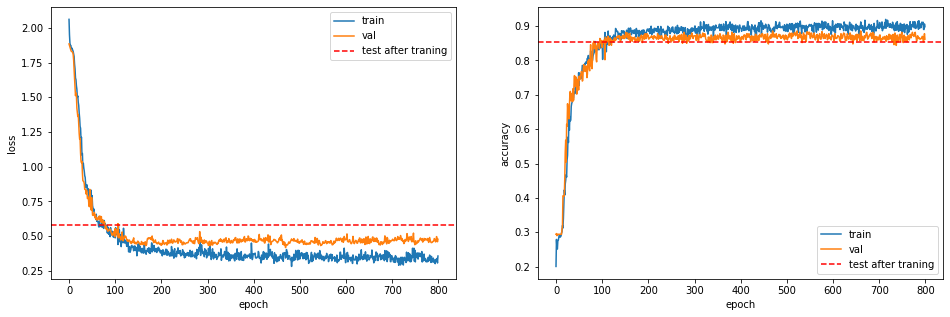

In [7]:
base_model = GCNModel(**model_args)

history = fit_model(base_model, idx_train, idx_val, num_epochs=800, verbose=100)

test_loss, test_acc = test_model(base_model, test_adj, test_fea)
print("TEST: acc={:.3}; loss={:.3}".format(test_acc, test_loss))

plot_history(history, test_loss, test_acc)

In [6]:
sn_model = GCNModel(**model_args)

history_sn = fit_model(sn_model, idx_train, idx_val, num_epochs=800, verbose=100, normalize=[1])

test_loss, test_acc = test_model(sn_model, test_adj, test_fea)
print("TEST: acc={:.3}; loss={:.3}".format(test_acc, test_loss))

plot_history(history_sn, test_loss, test_acc)

Normalize
>> Parameter containing:
tensor([[-0.0166, -0.0061,  0.0128,  ...,  0.0393,  0.0153, -0.0250],
        [-0.0665,  0.0718,  0.0518,  ..., -0.0635,  0.0575, -0.0311],
        [ 0.0357, -0.0857, -0.0391,  ..., -0.0673,  0.0695,  0.0014],
        ...,
        [ 0.0198,  0.0001, -0.0627,  ...,  0.0594,  0.0871, -0.0580],
        [-0.0830,  0.0364,  0.0674,  ...,  0.0111,  0.0719, -0.0502],
        [ 0.0689, -0.0879, -0.0462,  ...,  0.0326, -0.0320, -0.0528]],
       requires_grad=True) tensor(1.1396, grad_fn=<SelectBackward>)
Parameter containing:
tensor([[-1.4554e-02, -5.3116e-03,  1.1210e-02,  ...,  3.4496e-02,
          1.3442e-02, -2.1927e-02],
        [-5.8358e-02,  6.2985e-02,  4.5438e-02,  ..., -5.5764e-02,
          5.0420e-02, -2.7278e-02],
        [ 3.1308e-02, -7.5216e-02, -3.4273e-02,  ..., -5.9037e-02,
          6.0976e-02,  1.2449e-03],
        ...,
        [ 1.7415e-02,  9.2837e-05, -5.4982e-02,  ...,  5.2090e-02,
          7.6435e-02, -5.0854e-02],
        [-7.2829

KeyboardInterrupt: 

### Weight analysis

In [8]:
def multicollinearyty_det_factor(weight):
    weight = weight.astype(np.float64)
    det = np.linalg.det(weight)
    return det

In [9]:
layer = base_model.midlayer[0].model.hiddenlayers[0]
base_weight = layer.weight

In [10]:
det_of_wwT = multicollinearyty_det_factor(base_weight.detach().numpy())
print("Determinant of WW^T: ", det_of_wwT)

Determinant of WW^T:  -0.0


In [11]:
base_model.midlayer[0].model.hiddenlayers[0].weight.dtype

torch.float32

Text(0.5, 0, 'i')

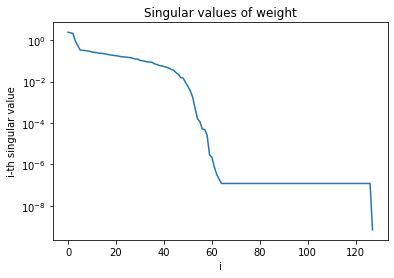

In [12]:
U, s, V = torch.svd(base_weight)

plt.title("Singular values of weight")
plt.plot(s.detach().numpy())
plt.yscale('log')
plt.ylabel("i-th singular value")
plt.xlabel("i")

7.522100460410501e-05


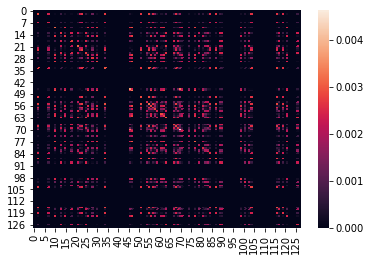

In [13]:
cov = pd.DataFrame(base_weight.detach().numpy()).cov()
sns.heatmap(cov.apply(abs))
print(cov.mean().mean())

In [23]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
#     new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    new_model.midlayer[0].model.hiddenlayers[0] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[0], r)
#     new_model.midlayer[0].model.hiddenlayers[1] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[1], r)
#     new_model.midlayer[0].model.hiddenlayers[2] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[2], r)
#     new_model.to(device)
    return new_model

Text(0, 0.5, 'determinant of weight')

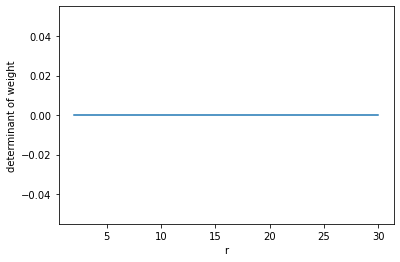

In [24]:
singular_values = defaultdict(list)
r_hist = []
for r in range(2, 31):
    new_model = make_new_model(base_model, r)
    fit_model(new_model, idx_train, idx_val, num_epochs=50, verbose=0)
    
    svd_layer = new_model.midlayer[0].model.hiddenlayers[0]
    svd_weight = torch.mm(torch.mm(svd_layer.U, torch.diag(svd_layer.s)), svd_layer.Vt).detach().numpy()
    r_hist.append((r, multicollinearyty_det_factor(svd_weight)))
    
    singular_values[r] = svd_layer.s.detach().numpy()
    
r_hist = np.array(r_hist)
plt.plot(r_hist[:, 0], r_hist[:, 1])
plt.xlabel('r')
plt.ylabel('determinant of weight')

Text(0.5, 0, 'i')

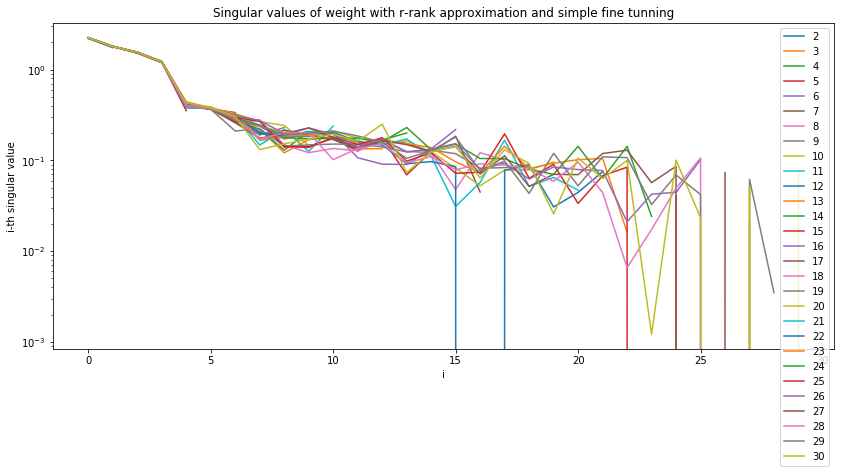

In [25]:
plt.figure(figsize=(14, 6))
plt.title("Singular values of weight with r-rank approximation and simple fine tunning")

for r in singular_values.keys():
    plt.plot(singular_values[r], label=r)
    
plt.legend()
plt.ylabel("i-th singular value")
plt.yscale('log')
plt.xlabel("i")

0.00012526943453132228


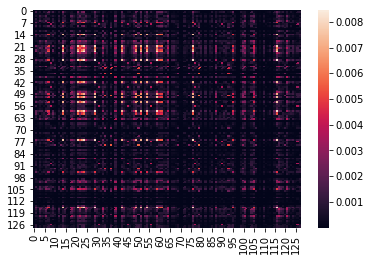

In [26]:
cov = pd.DataFrame(svd_weight).cov()
sns.heatmap(cov.apply(abs))
print(cov.mean().mean())

## TODO:
* дообучать слои по одному. Разложил 1 слой, дообучил, разложил 2 и тд
* отбор колонок в матрице (снижение размерности)

* **ОПТИОНАЛЬНО** Обучение нейронки по блокам: Замораживаем 1 блок, обучаем. Замораживаем другой блок, обучаем и тд

In [38]:
num_epochs_per_layer = 60
r = 7

new_model = copy.deepcopy(base_model)
parallel_traning_history = []
parallel_traning_history_test = []
for i in range(model_args['nbaselayer']):
    new_model.midlayer[0].model.hiddenlayers[i] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i], r)
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    parallel_traning_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    parallel_traning_history_test.append((test_loss, test_acc))
    print("Fitted model after decompose {}-th hiddenlayer.".format(i))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

Fitted model after decompose 0-th hiddenlayer.
TEST: acc=0.788; loss=0.703

Fitted model after decompose 1-th hiddenlayer.
TEST: acc=0.691; loss=0.898

Fitted model after decompose 2-th hiddenlayer.
TEST: acc=0.65; loss=0.955

Fitted model after decompose 3-th hiddenlayer.
TEST: acc=0.682; loss=0.932

Fitted model after decompose 4-th hiddenlayer.
TEST: acc=0.733; loss=0.876



In [39]:
new_model = copy.deepcopy(base_model)
train_only_decomposed_history = []
train_only_decomposed_history_test = []
for i in range(model_args['nbaselayer']):
    new_model.requires_grad_(False)
    
    new_model.midlayer[0].model.hiddenlayers[i] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i], r)
    new_model.midlayer[0].model.hiddenlayers[i].requires_grad_(True)
    
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    train_only_decomposed_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    train_only_decomposed_history_test.append((test_loss, test_acc))
    print("Fitted model after decompose {}-th hiddenlayer.".format(i))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

Fitted model after decompose 0-th hiddenlayer.
TEST: acc=0.797; loss=0.783

Fitted model after decompose 1-th hiddenlayer.
TEST: acc=0.797; loss=0.797

Fitted model after decompose 2-th hiddenlayer.
TEST: acc=0.8; loss=0.758

Fitted model after decompose 3-th hiddenlayer.
TEST: acc=0.795; loss=0.75

Fitted model after decompose 4-th hiddenlayer.
TEST: acc=0.794; loss=0.724



In [40]:
new_model = copy.deepcopy(base_model)
just_ft_history = []
just_ft_history_test = []
for i in range(model_args['nbaselayer']):
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    just_ft_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    just_ft_history_test.append((test_loss, test_acc))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

TEST: acc=0.782; loss=0.777

TEST: acc=0.821; loss=0.659

TEST: acc=0.835; loss=0.635

TEST: acc=0.843; loss=0.623

TEST: acc=0.795; loss=0.764



In [41]:
def concat_list_of_histories(lst_of_histories):
    history = defaultdict(list)
    for key in lst_of_histories[0].keys():
        for history_i in lst_of_histories:
            history[key] += history_i[key]
    return history

In [42]:
_parallel_traning_history = concat_list_of_histories(parallel_traning_history)
_train_only_decomposed_history = concat_list_of_histories(train_only_decomposed_history)
_just_ft_history = concat_list_of_histories(just_ft_history)

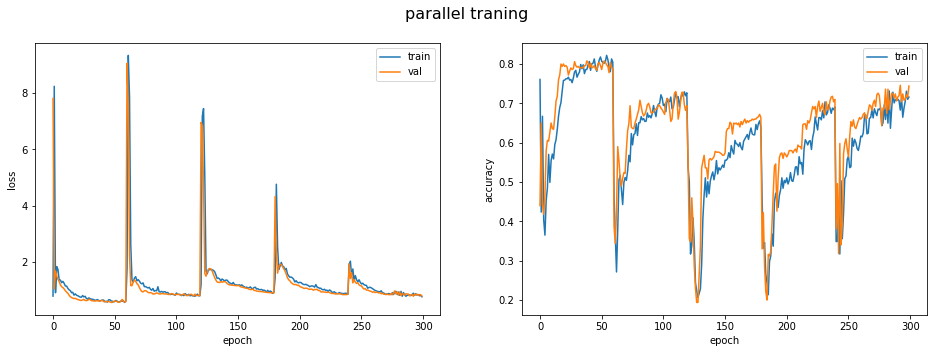

In [43]:
plot_history(_parallel_traning_history, title="parallel traning")

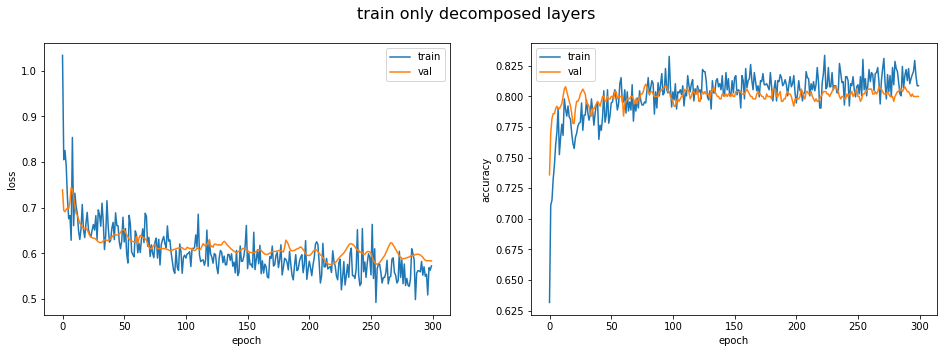

In [44]:
plot_history(_train_only_decomposed_history, title="train only decomposed layers")

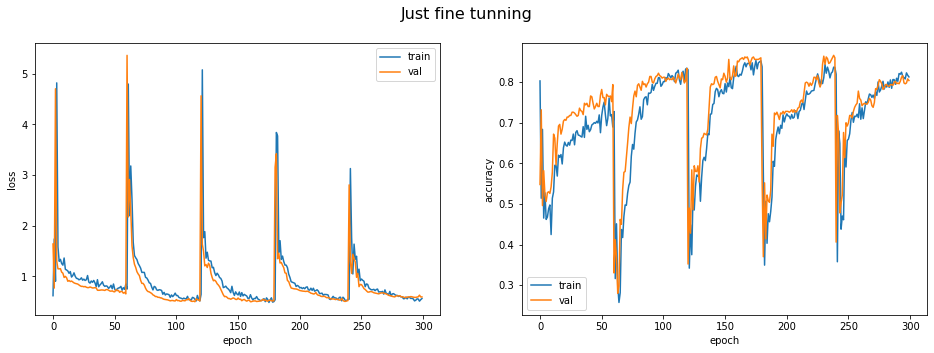

In [45]:
plot_history(_just_ft_history, title="Just fine tunning")

Text(0, 0.5, 'acc')

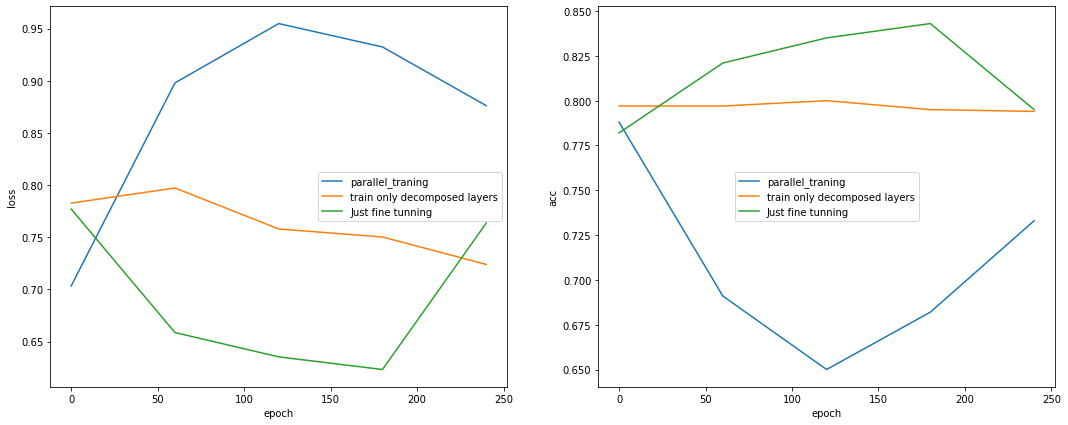

In [46]:
parallel_traning_history_test = np.array(parallel_traning_history_test)
train_only_decomposed_history_test = np.array(train_only_decomposed_history_test)
just_ft_history_test = np.array(just_ft_history_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

xx = [num_epochs_per_layer*i for i in range(model_args['nbaselayer'])]

axs[0].plot(xx, parallel_traning_history_test[:, 0], label="parallel_traning")
axs[0].plot(xx, train_only_decomposed_history_test[:, 0], label="train only decomposed layers")
axs[0].plot(xx, just_ft_history_test[:, 0], label="Just fine tunning")
axs[0].legend()
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")

axs[1].plot(xx, parallel_traning_history_test[:, 1], label="parallel_traning")
axs[1].plot(xx, train_only_decomposed_history_test[:, 1], label="train only decomposed layers")
axs[1].plot(xx, just_ft_history_test[:, 1], label="Just fine tunning")
axs[1].legend()
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("acc")